# Spend Analyzer

Spend Analyzer can help the customers in following ways:
- Summarizes all credit card transactions and records according to categories.
- Transforms monthly statement from a mere list of expenses to an effective budgeting tool.
- Helps in planning expenses for the coming months.
- Eliminates tedious manual tracking of card usages. 

## Part 1 : Categorize the Purchases from Transaction's Description Using Text Classification
Steps:
* Import the dataset
* Transform text into numerical vector data using a pipeline
* Create a classifier
* Fit/train the classifier
* Test the classifier on new data
* Evaluate performance

### Perform imports and load the dataset
The dataset contains the text of Transaction Details for various purchases.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np 
pd.options.display.float_format = '{:,.2f}'.format
import psycopg2 as pg
v3_conn = pg.connect(host="localhost",port=5412,database="production",user="aakashm",password="bDbf7dJdq69CUBpC")

In [2]:
df = pd.read_csv('txn_category.csv')
df = df[['description','category']]
df.head()

,description,category
0,YOGI GENERAL STORE JASDAN IN,General Store
1,YOGI GENERAL STORE JASDAN IN,General Store
2,YOGI GENERAL STORE JASDAN IN,General Store
3,Paytail 8047091893 IN,Payment/Finance
4,PHONEPE RENTAL BANGALORE IN,Rental


In [3]:
# Size of Dataset
len(df)

5549

### Take a quick look at the `Category` column:

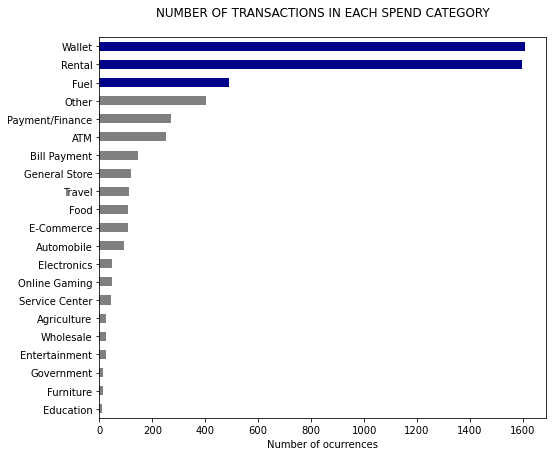

In [4]:
fig = plt.figure(figsize=(8,7))
colors = ['grey']*18 + ['darkblue','darkblue','darkblue']
df['category'].value_counts().sort_values().plot.barh(
    ylim=0, color=colors, title= 'NUMBER OF TRANSACTIONS IN EACH SPEND CATEGORY\n')
plt.xlabel('Number of ocurrences', fontsize = 10);

In [5]:
df['category'].value_counts()

Wallet             1606
Rental             1596
Fuel                490
Other               403
Payment/Finance     271
ATM                 253
Bill Payment        145
General Store       121
Travel              112
Food                106
E-Commerce          106
Automobile           91
Electronics          48
Online Gaming        46
Service Center       45
Agriculture          26
Wholesale            24
Entertainment        23
Government           14
Furniture            13
Education            10
Name: category, dtype: int64

### Split the data into train & test sets:

In [6]:
from sklearn.model_selection import train_test_split

X = df['description']
y = df['category']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

### Build pipelines to vectorize the data, then train and fit a model
Now that we have sets to train and test, we'll develop a selection of pipelines, each with a different model.

In [7]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC

# Linear SVC:
text_clf_lsvc = Pipeline([('tfidf', TfidfVectorizer()),('clf', LinearSVC()),])

### Feed the training data through the pipeline
Next we'll run Linear SVC

In [8]:
text_clf_lsvc.fit(X_train, y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', LinearSVC())])

### Run predictions and analyze the results (Linear SVC)

In [9]:
# Form a prediction set
predictions = text_clf_lsvc.predict(X_test)

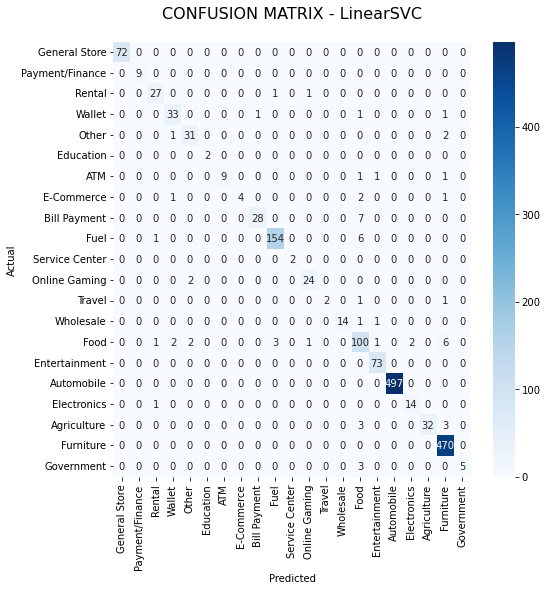

In [10]:
# Confusion Matrix
from sklearn import metrics
conf_mat = metrics.confusion_matrix(y_test, predictions)
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d',
            xticklabels=df.category.unique(), 
            yticklabels=df.category.unique())
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX - LinearSVC\n", size=16);



In [11]:
# Print a classification report
print(metrics.classification_report(y_test,predictions))

                 precision    recall  f1-score   support

            ATM       1.00      1.00      1.00        72
    Agriculture       1.00      1.00      1.00         9
     Automobile       0.90      0.93      0.92        29
   Bill Payment       0.89      0.92      0.90        36
     E-Commerce       0.89      0.91      0.90        34
      Education       1.00      1.00      1.00         2
    Electronics       1.00      0.75      0.86        12
  Entertainment       1.00      0.50      0.67         8
           Food       0.97      0.80      0.88        35
           Fuel       0.97      0.96      0.97       161
      Furniture       1.00      1.00      1.00         2
  General Store       0.92      0.92      0.92        26
     Government       1.00      0.50      0.67         4
  Online Gaming       1.00      0.88      0.93        16
          Other       0.80      0.85      0.82       118
Payment/Finance       0.96      1.00      0.98        73
         Rental       1.00    

In [12]:
# Print the overall accuracy
print(metrics.accuracy_score(y_test,predictions))

0.9621621621621622


In [13]:
# Now lets train the model using full dataset
text_clf_lsvc.fit(X, y)
# Form a prediction set
predictions = text_clf_lsvc.predict(X)
# Print the overall accuracy
print(metrics.accuracy_score(y,predictions))

0.9980176608397909


## Part 2 : Build Spend Analyzer

Transactions : 

In [14]:
txn = pd.read_sql_query(''' select ld.user_id,
date_trunc('month', txn_time)::date txn_month,
txn_time AS txn_date,
amount,
source,
description 
from card_transaction ct
join loan_data ld on ld.id = ct.loan_id
where ld.user_id IN
(SELECT user_id
FROM user_product up
WHERE product_type ='redcarpet_gimbooks')
and ct.status = 'CONFIRMED' ''', v3_conn)

txn.txn_date=pd.to_datetime(txn.txn_date)
txn.txn_month=pd.to_datetime(txn.txn_month)

C:\Users\hp\anaconda3\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


In [15]:
txn

,user_id,txn_month,txn_date,amount,source,description
0,2444446,2022-02-01,2022-02-15 15:36:29.347067,"10,000.00",POS,YOGI GENERAL STORE JASDAN IN
1,2444446,2022-02-01,2022-02-15 15:37:36.502323,"9,999.00",POS,YOGI GENERAL STORE JASDAN IN
2,2444446,2022-02-01,2022-02-15 15:38:13.932733,"9,998.00",POS,YOGI GENERAL STORE JASDAN IN
3,2477526,2022-02-01,2022-02-15 15:44:21.296575,"5,000.00",ECOM,Paytail 8047091893 IN
4,2452224,2022-02-01,2022-02-15 16:00:47.131713,"44,999.48",ECOM,PHONEPE RENTAL BANGALORE IN
...,...,...,...,...,...,...
5510,2455100,2022-06-01,2022-06-18 18:26:11.219746,14.99,FUND_POST,MOHAN SHIVA SER
5511,2420901,2022-07-01,2022-07-01 16:31:50.711472,"9,922.50",ECOM,PaytmRentPayment 201301 IN
5512,2420901,2022-07-01,2022-07-01 16:33:18.349135,"9,973.13",ECOM,PaytmRentPayment 201301 IN
5513,2420901,2022-07-01,2022-07-01 16:34:37.894949,"9,922.50",ECOM,PaytmRentPayment 201301 IN


In [16]:
# Predict using Linear SVC Model
predictions = text_clf_lsvc.predict(txn.description)

In [17]:
# Adding Predictions to Transactions DataFrame
txn['category'] = predictions

In [18]:
txn

,user_id,txn_month,txn_date,amount,source,description,category
0,2444446,2022-02-01,2022-02-15 15:36:29.347067,"10,000.00",POS,YOGI GENERAL STORE JASDAN IN,General Store
1,2444446,2022-02-01,2022-02-15 15:37:36.502323,"9,999.00",POS,YOGI GENERAL STORE JASDAN IN,General Store
2,2444446,2022-02-01,2022-02-15 15:38:13.932733,"9,998.00",POS,YOGI GENERAL STORE JASDAN IN,General Store
3,2477526,2022-02-01,2022-02-15 15:44:21.296575,"5,000.00",ECOM,Paytail 8047091893 IN,Payment/Finance
4,2452224,2022-02-01,2022-02-15 16:00:47.131713,"44,999.48",ECOM,PHONEPE RENTAL BANGALORE IN,Rental
...,...,...,...,...,...,...,...
5510,2455100,2022-06-01,2022-06-18 18:26:11.219746,14.99,FUND_POST,MOHAN SHIVA SER,Service Center
5511,2420901,2022-07-01,2022-07-01 16:31:50.711472,"9,922.50",ECOM,PaytmRentPayment 201301 IN,Rental
5512,2420901,2022-07-01,2022-07-01 16:33:18.349135,"9,973.13",ECOM,PaytmRentPayment 201301 IN,Rental
5513,2420901,2022-07-01,2022-07-01 16:34:37.894949,"9,922.50",ECOM,PaytmRentPayment 201301 IN,Rental


In [19]:
spend = txn[(txn.user_id==2444446) & (txn.txn_month=='2022-02-01')][['category','amount']].groupby('category').sum().reset_index().sort_values("amount",axis=0,ascending = False)

In [20]:
spend

,category,amount
0,General Store,"29,997.00"
3,Wallet,"10,555.50"
2,Rental,"9,927.40"
1,Other,"6,268.00"


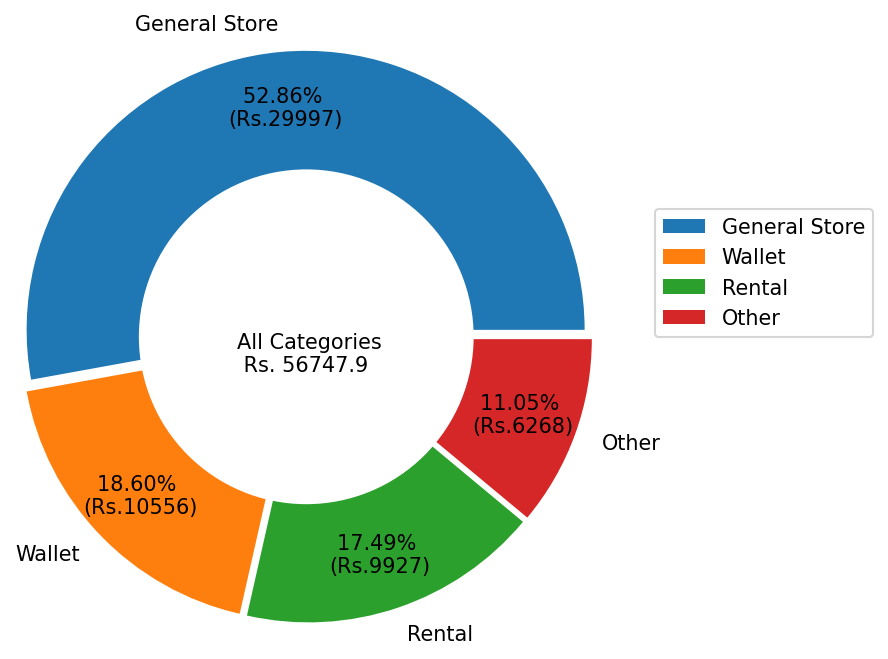

In [21]:
def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{p:.2f}% \n(Rs.{v:d})'.format(p=pct,v=val)
    return my_autopct
# explosion
explode = [0.05]*len(spend)

plt.figure(dpi=150, figsize = (3,6))
plt.pie(spend['amount'], labels=spend['category'],
        autopct=make_autopct(spend['amount']), pctdistance=0.80,radius=2,
        explode=explode)
  
# draw circle
centre_circle = plt.Circle((0, 0), 1.20 , fc='white')
label = plt.annotate(f"All Categories \n Rs. {sum(spend['amount'])}", xy=(-0.5, -0.25), fontsize=10)
fig = plt.gcf()
  
# Adding Circle in Pie chart
fig.gca().add_artist(centre_circle)

# Labels
plt.legend(spend['category'],loc=(1.5,0.5))

# Displaying Chart
plt.show()